In [1]:
import os
import csv
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.utils import resample
from scipy.stats import sem, t
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import chi2
#warnings.filterwarnings('ignore', category=UndefinedMetricWarning)
np.seterr(all='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
def calculate_auc_with_ci(df, column, label, random_state=42):
    np.random.seed(random_state)  # Set the seed for reproducibility
    
    aucs = []
    pr_aucs = []
    max_f1_scores = []  
    fprs = []  # False Positive Rate
    n_bootstrap = 200
    
    for _ in range(n_bootstrap):
        # Separate the data into positive and negative classes
        positive = df[df[label] == 1]
        negative = df[df[label] == 0]
        min_size = min(len(positive), len(negative))
        positive_resampled = resample(positive, replace=False, n_samples=min_size)
        negative_resampled = resample(negative, replace=False, n_samples=min_size)
        sample = pd.concat([positive_resampled, negative_resampled])
        sample = resample(sample, replace=True)
        sample = sample.dropna(subset=[label, column])
        if sample.empty:
            continue
        try:
            # Calculate AUC and PR AUC
            auc = roc_auc_score(sample[label], sample[column])
            aucs.append(auc)
            pr_auc = average_precision_score(sample[label], sample[column])
            pr_aucs.append(pr_auc)
            
            # Calculate FPR, TPR, and F1 Score at thresholds
            fpr, tpr, thresholds = roc_curve(sample[label], sample[column])
            specificity = 1 - fpr
            f1_scores_at_thresholds = 2 * (tpr * specificity) / (tpr + specificity + 1e-10)  
            max_f1_index = np.argmax(f1_scores_at_thresholds)
            max_f1 = f1_scores_at_thresholds[max_f1_index]
            max_f1_scores.append(max_f1)
            
            # Calculate False Positive Rate (FPR) at max F1 threshold
            fprs.append(fpr[max_f1_index])  # Store FPR at the threshold where F1 is maximized
            
        except ValueError:
            pass
    
    # Calculate Confidence Intervals for metrics
    auc_ci = t.interval(0.95, len(aucs) - 1, loc=np.mean(aucs), scale=sem(aucs))
    pr_auc_ci = t.interval(0.95, len(pr_aucs) - 1, loc=np.mean(pr_aucs), scale=sem(pr_aucs))
    max_f1_ci = t.interval(0.95, len(max_f1_scores) - 1, loc=np.mean(max_f1_scores), scale=sem(max_f1_scores))
    fpr_ci = t.interval(0.95, len(fprs) - 1, loc=np.mean(fprs), scale=sem(fprs))

    return (
        np.mean(aucs), auc_ci,
        np.mean(pr_aucs), pr_auc_ci,
        np.mean(max_f1_scores), max_f1_ci,
        np.mean(fprs), fpr_ci
    )

In [3]:
disorder_results_df = pd.read_csv('disorder_results_with_dbNSFP.tsv', sep='\t')
ordered_results_df = pd.read_csv('ordered_regions_results_with_dbNSFP.tsv', sep='\t')
gene_list_df = pd.read_csv('../cancerGeneList.tsv', sep='\t')


def binary_class(x):
    if x == 'Deleterious':
        return int(1)
    else:
        return int(0)

disorder_results_df['label'] = disorder_results_df['Class'].apply(lambda x:binary_class(x))
ordered_results_df['label'] = ordered_results_df['Class'].apply(lambda x:binary_class(x))


onco_gene_list = gene_list_df[gene_list_df['Is Oncogene'] == 'Yes']['Hugo Symbol'].tolist()
ts_gene_list = gene_list_df[gene_list_df['Is Tumor Suppressor Gene'] == 'Yes']['Hugo Symbol'].tolist()
disorder_results_df['onco_gene'] = np.where(disorder_results_df['GENES'].isin(onco_gene_list), 1, 0)
disorder_results_df['ts_gene'] = np.where(disorder_results_df['GENES'].isin(ts_gene_list), 1, 0)


ordered_results_df['onco_gene'] = np.where(ordered_results_df['CAVA_GENE'].isin(onco_gene_list), 1, 0)
ordered_results_df['ts_gene'] = np.where(ordered_results_df['CAVA_GENE'].isin(ts_gene_list), 1, 0)





In [4]:
disorder_results_onco_df = disorder_results_df[disorder_results_df['onco_gene'] == 1]
disorder_results_ts_df = disorder_results_df[disorder_results_df['ts_gene'] == 1]

ordered_results_onco_df = ordered_results_df[ordered_results_df['onco_gene'] == 1]
ordered_results_ts_df = ordered_results_df[ordered_results_df['ts_gene'] == 1]
ordered_results_ts_df.Class.value_counts()

ordered_results_ts_df

,#CHROM,POS,ID,REF,ALT,CAVA_CLASS,CAVA_CSN,CAVA_GENE,CAVA_IMPACT,CAVA_LOC,...,phyloP17way_primate_rankscore,phastCons100way_vertebrate_rankscore,phastCons470way_mammalian_rankscore,phastCons17way_primate_rankscore,SiPhy_29way_logOdds_rankscore,bStatistic_converted_rankscore,mutations,label,onco_gene,ts_gene
295,chr5,112154980,428172,T,A,NSY,c.1251T>A_p.Cys417Trp,APC,2,Ex10,...,0.62972,0.71638,0.68203,0.97212,0.45979,0.63909,C417W,1,0,1
296,chr5,112157621,623123,T,A,NSY,c.1341T>A_p.Cys447Trp,APC,2,Ex11,...,0.62972,0.29521,0.24702,0.57271,0.58210,0.63909,C447W,1,0,1
297,chr5,112157633,857174,T,A,NSY,c.1353T>A_p.Cys451Trp,APC,2,Ex11,...,0.62972,0.71638,0.68203,0.45669,0.40228,0.63909,C451W,1,0,1
298,chr5,112163652,2583954,C,A,NSY,c.1575C>A_p.Cys525Trp,APC,2,Ex13,...,0.40250,0.71638,0.68203,0.91618,0.57420,0.64743,C525W,1,0,1
299,chr5,112173274,469727,T,A,NSY,c.1983T>A_p.Cys661Trp,APC,2,Ex16,...,0.08892,0.71638,0.32793,0.67800,0.32907,0.66512,C661W,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1434,chr17,56770111,2445289,A,G,NSY,c.107A>G_p.Glu36Gly,RAD51C,2,Ex1,...,0.94297,0.71638,0.68203,0.53726,0.70081,0.71143,E36G,0,0,1
1435,chr17,56772522,132721,G,A,NSY,c.376G>A_p.Ala126Thr,RAD51C,2,Ex2,...,0.69459,0.71638,0.68203,0.97212,0.38383,0.71484,A126T,0,0,1
1436,chr17,56798128,132702,A,G,NSY,c.859A>G_p.Thr287Ala,RAD51C,2,Ex6,...,0.84096,0.71638,0.68203,0.97212,0.53768,0.72751,T287A,0,0,1
1437,chr17,56798139,184581,T,A,NSY,c.870T>A_p.Ile290Met,RAD51C,2,Ex6,...,0.47794,0.71638,0.68203,0.76049,0.33736,0.72751,I290M,0,0,1


In [5]:

dbnsfp_predictors =  [column for column in disorder_results_df.columns if column.endswith('rankscore')]

# Replace missing values with np.nan instead of '.'
disorder_results_df = disorder_results_df.replace('.', np.nan)
ordered_results_df = ordered_results_df.replace('.', np.nan)
# Convert the rankscore columns to float, which will now work since '.' is replaced with NaN
disorder_results_df[dbnsfp_predictors] = disorder_results_df[dbnsfp_predictors].astype(float)
ordered_results_df[dbnsfp_predictors] = ordered_results_df[dbnsfp_predictors].astype(float)


disorder_results_onco_df = disorder_results_onco_df.replace('.', np.nan)
disorder_results_onco_df[dbnsfp_predictors] = disorder_results_onco_df[dbnsfp_predictors].astype(float)
disorder_results_ts_df = disorder_results_ts_df.replace('.', np.nan)
disorder_results_ts_df[dbnsfp_predictors] = disorder_results_ts_df[dbnsfp_predictors].astype(float)
ordered_results_onco_df = ordered_results_onco_df.replace('.', np.nan)
ordered_results_onco_df[dbnsfp_predictors] = ordered_results_onco_df[dbnsfp_predictors].astype(float)
ordered_results_ts_df = ordered_results_ts_df.replace('.', np.nan)
ordered_results_ts_df[dbnsfp_predictors] = ordered_results_ts_df[dbnsfp_predictors].astype(float)


In [6]:
def calculate_metrics_and_store(results_df, dbnsfp_predictors, label_col, result_type):
    data_dict = {'name': [], 'AUC': [], 'AUC_CI_low': [], 'AUC_CI_high': [], 'PI_AUC': [],
                 'PR_AUC_low': [], 'PR_AUC_high': [],  'F1_Score': [],
                 'F1_CI_low': [], 'F1_CI_high': [], 'FRP_Score': [], 'FRP_CI_low': [],'FRP_CI_high': [],'TYPE': []}

    for predictor in dbnsfp_predictors:
        # Call the function to calculate metrics
        aucs, auc_ci, pr_aucs, pr_auc_ci, f1, f1_ci, fpr, fpr_ci = calculate_auc_with_ci(results_df, 
                                                                                        predictor, label_col)
        # Store the calculated values in the dictionary
        data_dict['name'].append(predictor)
        data_dict['AUC'].append(aucs)
        data_dict['AUC_CI_low'].append(auc_ci[0])
        data_dict['AUC_CI_high'].append(auc_ci[1])
        data_dict['PI_AUC'].append(pr_aucs)
        data_dict['PR_AUC_low'].append(pr_auc_ci[0])
        data_dict['PR_AUC_high'].append(pr_auc_ci[1])
        data_dict['F1_Score'].append(f1)
        data_dict['F1_CI_low'].append(f1_ci[0])
        data_dict['F1_CI_high'].append(f1_ci[1])
        data_dict['FRP_Score'].append(fpr)
        data_dict['FRP_CI_low'].append(fpr_ci[0])
        data_dict['FRP_CI_high'].append(fpr_ci[1])
        data_dict['TYPE'].append(result_type)
    
    # Convert the dictionary into a DataFrame and return it sorted by AUC
    result_df = pd.DataFrame(data_dict)
    result_df = result_df.sort_values(by="AUC", ascending=False)
    
    return result_df

In [7]:
result_disorder_df = calculate_metrics_and_store(disorder_results_df, dbnsfp_predictors, 'label', 'dbNSFP Predictor')
result_order_df = calculate_metrics_and_store(ordered_results_df, dbnsfp_predictors, 'label', 'dbNSFP Predictor')

/projects/wangc/rohan/miniconda3/envs/thesis/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/projects/wangc/rohan/miniconda3/envs/thesis/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/projects/wangc/rohan/miniconda3/envs/thesis/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/projects/wangc/rohan/miniconda3/envs/thesis/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [13]:
result_disorder_onco_df = calculate_metrics_and_store(disorder_results_onco_df, dbnsfp_predictors, 'label', 'dbNSFP Predictor')
result_order_onco_df = calculate_metrics_and_store(ordered_results_onco_df, dbnsfp_predictors, 'label', 'dbNSFP Predictor')

/projects/wangc/rohan/miniconda3/envs/thesis/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/projects/wangc/rohan/miniconda3/envs/thesis/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/projects/wangc/rohan/miniconda3/envs/thesis/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/projects/wangc/rohan/miniconda3/envs/thesis/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [12]:
result_disorder_ts_df = calculate_metrics_and_store(disorder_results_ts_df, dbnsfp_predictors, 'label', 'dbNSFP Predictor')
result_order_ts_df = calculate_metrics_and_store(ordered_results_ts_df, dbnsfp_predictors, 'label', 'dbNSFP Predictor')

/projects/wangc/rohan/miniconda3/envs/thesis/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/projects/wangc/rohan/miniconda3/envs/thesis/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/projects/wangc/rohan/miniconda3/envs/thesis/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/projects/wangc/rohan/miniconda3/envs/thesis/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [14]:


def process_dataframe_auc(df, region_value, remove_name='LINSIGHT_rankscore'):
    df['region'] = region_value
    df = df.sort_values(by="AUC", ascending=False)
    df = df[df['name'] != remove_name]
    df['name'] = df['name'].str.replace('_rankscore', '', regex=False)
    df['error_low'] = df['AUC'] - df['AUC_CI_low']
    df['error_high'] = df['AUC_CI_high'] - df['AUC']
    return df


def process_dataframe_auc_pr(df, region_value, remove_name='LINSIGHT_rankscore'):
    df['region'] = region_value
    df = df.sort_values(by="PI_AUC", ascending=False)
    df = df[df['name'] != remove_name]
    df['name'] = df['name'].str.replace('_rankscore', '', regex=False)
    df['error_low'] = df['PI_AUC'] - df['PR_AUC_low']
    df['error_high'] = df['PR_AUC_high'] - df['PI_AUC']
    return df


predictor_features = {
    'SIFT_converted': 'conservation',
    'SIFT4G_converted': 'conservation',
    'Polyphen2_HDIV': 'Structure',
    'Polyphen2_HVAR': 'Structure',
    'LRT_converted': 'conservation',
    'MutationTaster_converted': 'both',
    'MutationAssessor': 'both',
    'FATHMM_converted': 'both',
    'PROVEAN_converted': 'both',
    'VEST4': 'meta',
    'MetaSVM': 'meta',
    'MetaLR': 'meta',
    'MetaRNN': 'meta',
    'M-CAP': 'meta',
    'REVEL': 'meta',
    'MutPred': 'both',
    'MVP': 'meta',
    'gMVP': 'conservation',
    'MPC': 'meta',
    'PrimateAI': 'conservation',
    'DEOGEN2': 'both',
    'BayesDel_addAF': 'meta',
    'BayesDel_noAF': 'meta',
    'ClinPred': 'meta',
    'LIST-S2': 'meta',
    'VARITY_R': 'both',
    'VARITY_ER': 'both',
    'VARITY_R_LOO': 'both',
    'VARITY_ER_LOO': 'both',
    'ESM1b': 'Structure',
    'EVE': 'protein_sequence',
    'AlphaMissense': 'Structure',
    'PHACTboost': 'conservation',
    'MutFormer': 'protein_sequence',
    'CADD_raw': 'meta',
    'DANN': 'meta',
    'fathmm-MKL_coding': 'both',
    'fathmm-XF_coding': 'both',
    'Eigen-raw_coding': 'meta',
    'Eigen-PC-raw_coding': 'meta',
    'GenoCanyon': 'conservation',
    'integrated_fitCons': 'conservation',
    'GM12878_fitCons': 'conservation',
    'H1-hESC_fitCons': 'conservation',
    'HUVEC_fitCons': 'conservation',
    'GERP++_RS': 'conservation',
    'GERP_91_mammals': 'conservation',
    'phyloP100way_vertebrate': 'conservation',
    'phyloP470way_mammalian': 'conservation',
    'phyloP17way_primate': 'conservation',
    'phastCons100way_vertebrate': 'conservation',
    'phastCons470way_mammalian': 'conservation',
    'phastCons17way_primate': 'conservation',
    'SiPhy_29way_logOdds': 'conservation',
    'bStatistic_converted': 'conservation'
}

result_order_AUC_df = process_dataframe_auc(result_order_df, 'ordered')
result_disorder_AUC_df =  process_dataframe_auc(result_disorder_df, 'disordered') 
result_order_onco_AUC_df = process_dataframe_auc(result_order_onco_df, 'ordered')
result_disorder_onco_AUC_df =  process_dataframe_auc(result_disorder_onco_df, 'disordered') 
result_order_ts_AUC_df = process_dataframe_auc(result_order_ts_df, 'ordered')
result_disorder_ts_AUC_df =  process_dataframe_auc(result_disorder_ts_df, 'disordered') 


result_order_AUC_pr_df = process_dataframe_auc_pr(result_order_df, 'ordered')
result_disorder_AUC_pr_df =  process_dataframe_auc_pr(result_disorder_df, 'disordered') 
result_order_onco_AUC_pr_df = process_dataframe_auc_pr(result_order_onco_df, 'ordered')
result_disorder_onco_AUC_pr_df =  process_dataframe_auc_pr(result_disorder_onco_df, 'disordered') 
result_order_ts_AUC_pr_df = process_dataframe_auc_pr(result_order_ts_df, 'ordered')
result_disorder_ts_AUC_pr_df =  process_dataframe_auc_pr(result_disorder_ts_df, 'disordered') 



result_data_auc_df = pd.concat([result_order_AUC_df, result_disorder_AUC_df], axis=0)
result_data_auc_df = result_data_auc_df.reset_index(drop=True)

result_data_onco_auc_df = pd.concat([result_order_onco_AUC_df, result_disorder_onco_AUC_df], axis=0)
result_data_onco_auc_df = result_data_onco_auc_df.reset_index(drop=True)

result_data_ts_auc_df = pd.concat([result_order_ts_AUC_df, result_disorder_ts_AUC_df], axis=0)
result_data_ts_auc_df = result_data_ts_auc_df.reset_index(drop=True)


result_data_auc_pr_df = pd.concat([result_order_AUC_pr_df, result_disorder_AUC_pr_df], axis=0)
result_data_auc_pr_df = result_data_auc_pr_df.reset_index(drop=True)

result_data_onco_auc_pr_df = pd.concat([result_order_onco_AUC_pr_df, result_disorder_onco_AUC_pr_df], axis=0)
result_data_onco_auc_pr_df = result_data_onco_auc_pr_df.reset_index(drop=True)

result_data_ts_auc_pr_df = pd.concat([result_order_ts_AUC_pr_df, result_disorder_ts_AUC_pr_df], axis=0)
result_data_ts_auc_pr_df = result_data_ts_auc_pr_df.reset_index(drop=True)

result_data_auc_df['feature'] = result_data_auc_df['name'].map(predictor_features)
result_data_onco_auc_df['feature'] = result_data_onco_auc_df['name'].map(predictor_features)
result_data_ts_auc_df['feature'] = result_data_ts_auc_df['name'].map(predictor_features)


result_data_onco_auc_df.to_csv("oncogenes_metrics_results.csv", index=False)
result_data_auc_df.to_csv("all_genes_metrics_results.csv", index=False)
result_data_ts_auc_df.to_csv("ts_genes_metrics_results.csv", index=False)

/tmp/ipykernel_1449184/1637244189.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  barplot = sns.barplot(x=x_col, y=y_col, hue=hue_col, data=df, ci=None,


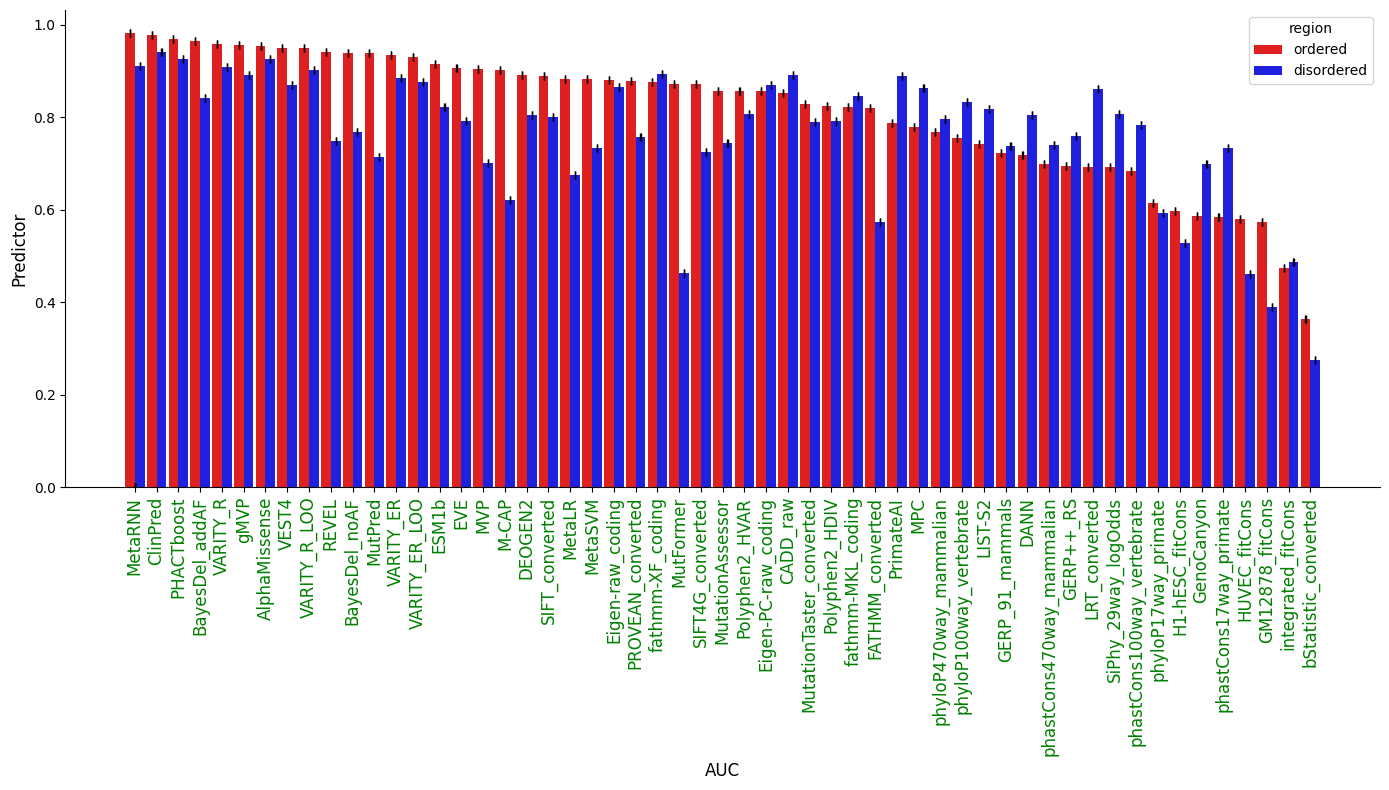

In [15]:

category_colors = {
    'conservation': 'green',
    'both': 'orange',
    'meta': 'purple',
    'structural': 'blue',
    'protein_sequence': 'red'
}

def color_labels_by_category(ax, predictor_features, category_colors):
    for label in ax.get_xticklabels():
        predictor_name = label.get_text()
        category = predictor_features.get(predictor_name, 'conservation')  
        label.set_color(category_colors.get(category, 'black')) 

def plot_auc_bar_with_error_bars(df, x_col='name', y_col='AUC', hue_col='region', 
                                 err_low_col='error_low', err_high_col='error_high', 
                                 palette={"ordered": "red", "disordered": "blue"}, 
                                 figsize=(14, 8), xlabel='AUC', ylabel='Predictor',
                                 predictor_features=predictor_features, category_colors=category_colors):
    plt.figure(figsize=figsize)
    barplot = sns.barplot(x=x_col, y=y_col, hue=hue_col, data=df, ci=None, 
                          capsize=0.01, dodge=1, width=0.9, palette=palette)
    for i, bar in enumerate(barplot.patches):
        bar_x = bar.get_x() + bar.get_width() / 2  
        err_low = df.iloc[i // 2][err_low_col]  
        err_high = df.iloc[i // 2][err_high_col] 
        auc_value = bar.get_width()  
        plt.errorbar(x=bar_x, y=bar.get_y() + bar.get_height(),
                     xerr=[[err_low], [err_high]],
                     fmt='none', c='black', capsize=3)

    plt.xticks(rotation=90, ha='center', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xlabel(xlabel, fontsize=12)
    sns.despine()
    color_labels_by_category(barplot, predictor_features, category_colors)
    plt.tight_layout()
    plt.show()

plot_auc_bar_with_error_bars(result_data_auc_df)



In [16]:
def compute_midrank(x):
    """Computes midranks.
    Args:
        x - a 1D numpy array
    Returns:
        array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5 * (i + j - 1)
        i = j
    T[J] = T + 1
    return T

def fastDeLong(predictions_sorted_transposed, label_1_count):
    """Fast DeLong implementation"""
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    pos_scores = predictions_sorted_transposed[:, :m]
    neg_scores = predictions_sorted_transposed[:, m:]
    Tx = np.concatenate(
        [compute_midrank(pos_scores[i, :]) for i in range(pos_scores.shape[0])]
    )
    Ty = np.concatenate(
        [compute_midrank(neg_scores[i, :]) for i in range(neg_scores.shape[0])]
    )
    return Tx, Ty

def delong_roc_test(ground_truth, predictions_one, predictions_two):
    """Performs the DeLong test"""
    assert len(predictions_one) == len(predictions_two)
    label_1_count = sum(ground_truth)
    tx1, tx2 = fastDeLong(np.vstack([predictions_one, predictions_two]).T, label_1_count)
    auc_variance = np.var([tx1, tx2])
    z_stat = (roc_auc_score(ground_truth, predictions_one) - roc_auc_score(ground_truth, predictions_two)) / np.sqrt(auc_variance)
    p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
    return p_value


def generate_balanced_data(df_ordered, df_disordered, column, random_seed=42):
    positive_ordered = df_ordered[df_ordered['label'] == 1]
    negative_ordered = df_ordered[df_ordered['label'] == 0]
    positive_disordered = df_disordered[df_disordered['label'] == 1]
    negative_disordered = df_disordered[df_disordered['label'] == 0]
    min_size_ordered = min(len(positive_ordered), len(negative_ordered))
    min_size_disordered = min(len(positive_disordered), len(negative_disordered))
    min_size =min(min_size_ordered, min_size_disordered)
    
    if min_size_ordered == 0 or min_size_disordered == 0:
        return [], [], [], []  
    positive_resampled_ordered = resample(positive_ordered, replace=False, n_samples=min_size)
    negative_resampled_ordered = resample(negative_ordered, replace=False, n_samples=min_size)
    positive_resampled_disordered = resample(positive_disordered, replace=False, n_samples=min_size)
    negative_resampled_disordered = resample(negative_disordered, replace=False, n_samples=min_size)
    
    sample_ordered = pd.concat([positive_resampled_ordered, negative_resampled_ordered])
    sample_disordered = pd.concat([positive_resampled_disordered, negative_resampled_disordered])
    sample_ordered = resample(sample_ordered, replace=True)
    sample_disordered = resample(sample_disordered, replace=True)
    sample_ordered = sample_ordered.dropna(subset=['label', column])
    sample_disordered = sample_disordered.dropna(subset=['label', column])
    ordered_pred_truth = sample_ordered['label'].to_numpy()
    ordered_pred_pred = sample_ordered[column].to_numpy()
    disordered_pred_truth = sample_disordered['label'].to_numpy()
    disordered_pred_pred = sample_disordered[column].to_numpy()
    return ordered_pred_truth, ordered_pred_pred, disordered_pred_truth, disordered_pred_pred

def bootstrap_auc_comparison(y_true_1, y_scores_1, y_true_2, y_scores_2, n_bootstraps=200, random_seed=42):
    np.random.seed(random_seed)
    
    if len(y_true_1) == 0 or len(y_true_2) == 0:
        raise ValueError("One of the input arrays (y_true_1 or y_true_2) is empty.")

    auc_differences = []
    p_values = []
    
    # Convert y_true and y_scores to NumPy arrays to avoid index issues
    y_true_1 = np.array(y_true_1)
    y_scores_1 = np.array(y_scores_1)
    y_true_2 = np.array(y_true_2)
    y_scores_2 = np.array(y_scores_2)
    
    # Calculate the observed AUC difference
    auc_1_obs = roc_auc_score(y_true_1, y_scores_1)
    auc_2_obs = roc_auc_score(y_true_2, y_scores_2)
    observed_diff = auc_1_obs - auc_2_obs
    
    # Bootstrap resampling
    for _ in range(n_bootstraps):
        indices_1 = resample(np.arange(len(y_true_1)), replace=True, stratify=y_true_1)
        indices_2 = resample(np.arange(len(y_true_2)), replace=True, stratify=y_true_2)

        y_true_resample_1 = y_true_1[indices_1]
        y_scores_resample_1 = y_scores_1[indices_1]
        y_true_resample_2 = y_true_2[indices_2]
        y_scores_resample_2 = y_scores_2[indices_2]

        # Calculate AUC for both resampled groups
        auc_1 = roc_auc_score(y_true_resample_1, y_scores_resample_1)
        auc_2 = roc_auc_score(y_true_resample_2, y_scores_resample_2)

        auc_differences.append(auc_1 - auc_2)

    auc_differences = np.array(auc_differences)

    # Calculate the mean, min, and max p-values
    mean_diff = np.mean(auc_differences)
    conf_int = np.percentile(auc_differences, [2.5, 97.5])
    
    # P-value as proportion of differences crossing zero (two-sided)
    p_value = np.mean(np.abs(auc_differences) >= np.abs(observed_diff)) * 2
    p_value = min(p_value, 1.0)

    return mean_diff, conf_int, p_value
        


def calculate_chisquare_pvalue(y_true_1, y_scores_1, y_true_2, y_scores_2, random_seed=42, num_bootstraps=200):
    np.random.seed(random_seed)
    
    if len(y_true_1) == 0 or len(y_true_2) == 0:
        raise ValueError("One of the input arrays (y_true_1 or y_true_2) is empty.")

    # Convert y_true and y_scores to NumPy arrays to avoid index issues
    y_true_1 = np.array(y_true_1)
    y_scores_1 = np.array(y_scores_1)
    y_true_2 = np.array(y_true_2)
    y_scores_2 = np.array(y_scores_2)
    
    # Calculate the observed AUCs
    auc_1_obs = roc_auc_score(y_true_1, y_scores_1)
    auc_2_obs = roc_auc_score(y_true_2, y_scores_2)
    
    # Calculate the observed difference in AUCs
    observed_auc_diff = abs(auc_1_obs - auc_2_obs)
    auc_1_boot_list = []
    auc_2_boot_list = []
    # Perform bootstrapping to estimate the sampling distribution of AUC differences
    auc_differences = []
    for _ in range(num_bootstraps):
        # Sample with replacement from both sets
        indices_1 = np.random.choice(len(y_true_1), len(y_true_1), replace=True)
        indices_2 = np.random.choice(len(y_true_2), len(y_true_2), replace=True)
        
        # Compute AUCs for the bootstrapped samples
        auc_1_boot = roc_auc_score(y_true_1[indices_1], y_scores_1[indices_1])
        auc_2_boot = roc_auc_score(y_true_2[indices_2], y_scores_2[indices_2])
        auc_1_boot_list.append(auc_1_boot)
        auc_2_boot_list.append(auc_2_boot)
        # Record the absolute difference
        auc_differences.append(abs(auc_1_boot - auc_2_boot))
    
    # Calculate the variance of the bootstrapped AUC differences
    variance_diff = np.var(auc_differences)
    
    # Compute chi-square statistic for the absolute observed difference
    chi_square_statistic = (observed_auc_diff ** 2) / variance_diff
    
    # Compute the p-value for a two-sided test (chi-square distribution with 1 degree of freedom)
    p_value = chi2.sf(chi_square_statistic, df=1) * 2  
    #chi_square_statistic = (observed_auc_diff ** 2) / variance_diff
    
    # Compute the p-value for a two-sided test (chi-square distribution with 1 degree of freedom)
    p_value = min(chi2.sf(chi_square_statistic, df=1) * 2, 1.0)
    
    return observed_auc_diff, chi_square_statistic,p_value, auc_1_boot_list, auc_2_boot_list
    


In [17]:
auc_diff_dict = {'Predictor': [], 'AUC_diff': [], 'chi_square_statistic': [], 'p-value': [], 
                 'auc_ordered':[], 'auc_disordered':[]}
for predictor in dbnsfp_predictors:
    ordered_pred_truth, ordered_pred_pred, disordered_pred_truth, disordered_pred_pred = generate_balanced_data(ordered_results_df,
                                                                                                                disorder_results_df, predictor) 

    if len(ordered_pred_truth) == 0 or len(disordered_pred_truth) == 0:
        print(f"Predictor {predictor} has insufficient data for comparison. Skipping.")
        continue
    
    # Proceed with AUC comparison if both groups have data
    auc_diff, chi_square_statistic,p_value, auc_ordered, auc_disordered = calculate_chisquare_pvalue(ordered_pred_truth, ordered_pred_pred, 
                                                            disordered_pred_truth, disordered_pred_pred)
    #print(auc_dict)
    auc_diff_dict['Predictor'].append(predictor)
    auc_diff_dict['AUC_diff'].append(auc_diff)
    auc_diff_dict['chi_square_statistic'].append(chi_square_statistic)
    auc_diff_dict['p-value'].append(p_value)
    auc_diff_dict['auc_ordered'].append(auc_ordered)
    auc_diff_dict['auc_disordered'].append(auc_disordered)

Predictor LINSIGHT_rankscore has insufficient data for comparison. Skipping.


In [18]:
auc_comparison_df = pd.DataFrame(auc_diff_dict)
auc_comparison_df['Predictor'] = auc_comparison_df['Predictor'].str.replace("_rankscore","")
auc_comparison_df = auc_comparison_df.sort_values(by="p-value", ascending=False)
auc_comparison_df['feature'] = auc_comparison_df['Predictor'].map(predictor_features)
auc_comparison_df

,Predictor,AUC_diff,chi_square_statistic,p-value,auc_ordered,auc_disordered,feature
24,LIST-S2,0.009724,0.305593,1.000000e+00,"[0.8012475243859551, 0.8442796610169492, 0.795...","[0.8209482723700733, 0.8198703187492425, 0.865...",meta
48,phyloP470way_mammalian,0.005298,0.070379,1.000000e+00,"[0.7748172701002889, 0.7746665099606276, 0.767...","[0.7493465700660309, 0.7746327889791077, 0.746...",conservation
38,Eigen-raw_coding,0.005538,0.104631,1.000000e+00,"[0.8687004134540173, 0.879986590680523, 0.8504...","[0.8618043684710351, 0.8355047647409172, 0.861...",meta
39,Eigen-PC-raw_coding,0.010977,0.363962,1.000000e+00,"[0.8406884707287933, 0.8726121892055791, 0.829...","[0.8617663817663819, 0.834313579511614, 0.8584...",meta
49,phyloP17way_primate,0.017752,0.516776,9.444407e-01,"[0.6237678796412955, 0.6004657901010435, 0.607...","[0.6264873202195425, 0.6079880470097468, 0.557...",conservation
40,GenoCanyon,0.016350,0.537310,9.270998e-01,"[0.6166513929618769, 0.6200529631997078, 0.625...","[0.6407356206275397, 0.6199613705072221, 0.655...",conservation
51,phastCons470way_mammalian,0.031078,1.664501,3.939935e-01,"[0.6799192996094545, 0.7045043564030906, 0.655...","[0.7341523341523342, 0.7118055555555555, 0.691...",conservation
2,Polyphen2_HDIV,0.031387,1.691425,3.868263e-01,"[0.7903061224489796, 0.796680458184883, 0.8047...","[0.8357558139534884, 0.798790658882402, 0.8307...",Structure
41,integrated_fitCons,0.045490,1.795614,3.604873e-01,"[0.46544159953970077, 0.4704997555747753, 0.48...","[0.4935323984526112, 0.49459321300774645, 0.46...",conservation
46,GERP_91_mammals,0.047447,1.967649,3.213953e-01,"[0.7058835213729541, 0.757487680936249, 0.7329...","[0.7823920265780732, 0.7439499756374858, 0.726...",conservation


In [19]:
auc_comparison_filter_df = auc_comparison_df[auc_comparison_df['p-value'] > 0.05]
auc_comparison_filter_df.to_csv("auc_sig_nobias.csv",index=False)
unbiased_predictors = auc_comparison_filter_df.Predictor.tolist()


auc_comparison_filter_biased_df = auc_comparison_df[auc_comparison_df['p-value'] < 0.05]
auc_comparison_filter_biased_df.to_csv("auc_sig_bias.csv",index=False)
biased_predictors = auc_comparison_filter_biased_df.Predictor.tolist()
biased_predictors

['GERP++_RS',
 'AlphaMissense',
 'phastCons100way_vertebrate',
 'ClinPred',
 'DANN',
 'VARITY_ER',
 'H1-hESC_fitCons',
 'VARITY_ER_LOO',
 'phastCons17way_primate',
 'ESM1b',
 'VARITY_R',
 'DEOGEN2',
 'VARITY_R_LOO',
 'bStatistic_converted',
 'PHACTboost',
 'PrimateAI',
 'SIFT_converted',
 'gMVP',
 'MutationAssessor',
 'PROVEAN_converted',
 'VEST4',
 'EVE',
 'LRT_converted',
 'MetaLR',
 'SIFT4G_converted',
 'HUVEC_fitCons',
 'MVP',
 'GM12878_fitCons',
 'MetaSVM',
 'MetaRNN',
 'BayesDel_addAF',
 'REVEL',
 'BayesDel_noAF',
 'MutPred',
 'FATHMM_converted',
 'M-CAP',
 'MutFormer']

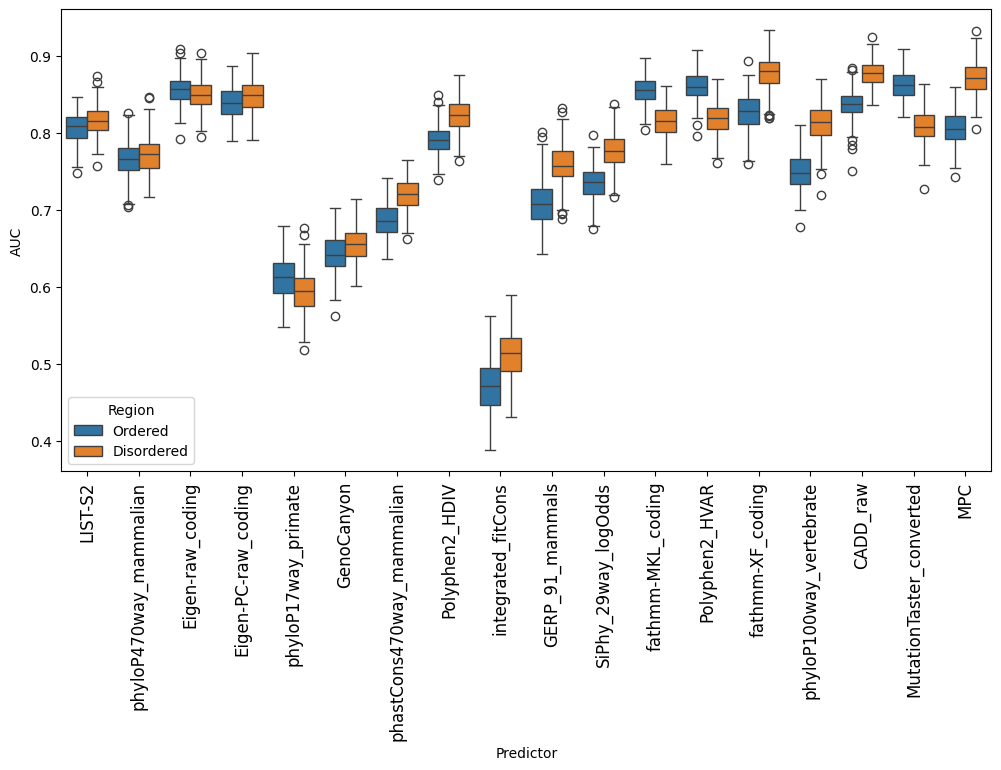

In [20]:
auc_plot_df = auc_comparison_df[['Predictor', 'auc_ordered', 'auc_disordered', 'feature']]
auc_plot_df

df_long = auc_plot_df.melt(id_vars=['Predictor', 'feature'], 
                  value_vars=['auc_ordered', 'auc_disordered'], 
                  var_name='Region', value_name='AUC')

df_long = df_long.explode('AUC').reset_index(drop=True)
df_long['AUC'] = df_long['AUC'].astype(float)
df_long['Region'] = df_long['Region'].replace({'auc_ordered': 'Ordered', 'auc_disordered': 'Disordered'}) 

df_long_ub = df_long[df_long['Predictor'].isin(unbiased_predictors)]
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_long_ub, x='Predictor', y='AUC', hue='Region')
#plt.title("Grouped Box Plot of AUC by Predictor and Region")

plt.xticks(rotation=90, ha='center', fontsize=12)
#plt.ylabel(ylabel, fontsize=12)
#plt.xlabel(xlabel, fontsize=12)
plt.ylabel("AUC")
plt.xlabel("Predictor")
plt.legend(title="Region")
plt.show()

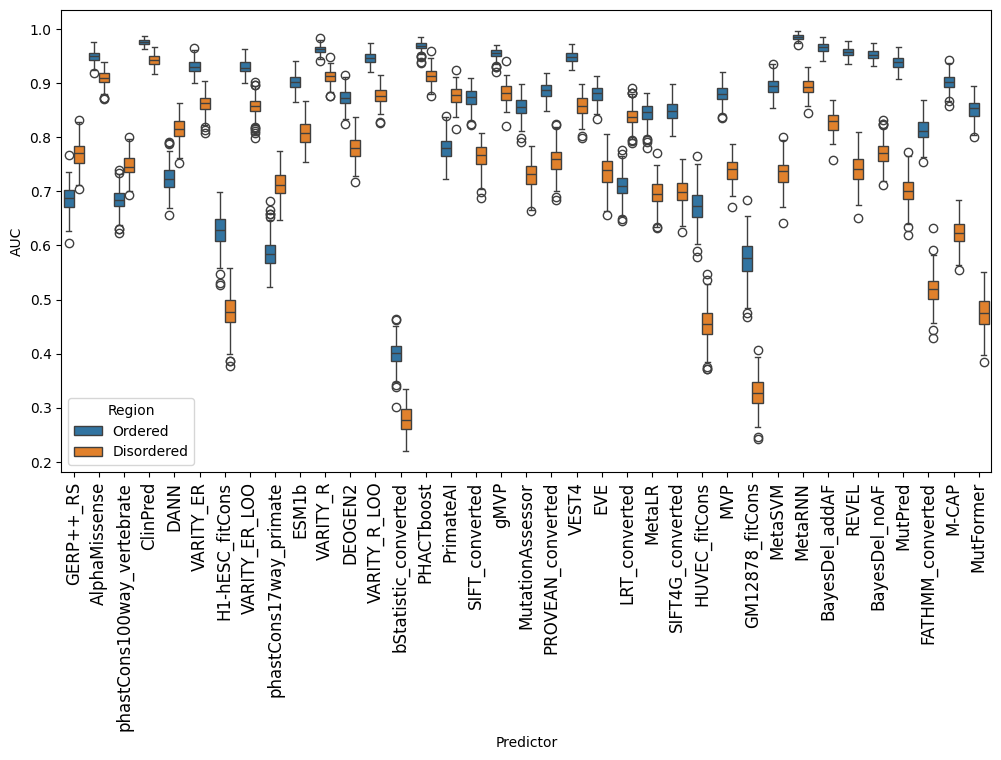

In [21]:
df_long_bi = df_long[df_long['Predictor'].isin(biased_predictors)]
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_long_bi, x='Predictor', y='AUC', hue='Region')
#plt.title("Grouped Box Plot of AUC by Predictor and Region")

plt.xticks(rotation=90, ha='center', fontsize=12)
#plt.ylabel(ylabel, fontsize=12)
#plt.xlabel(xlabel, fontsize=12)
plt.ylabel("AUC")
plt.xlabel("Predictor")
plt.legend(title="Region")
plt.show()

/tmp/ipykernel_1449184/3876845624.py:6: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=result_data_auc_plot_df, x='feature', y='AUC', hue='region',


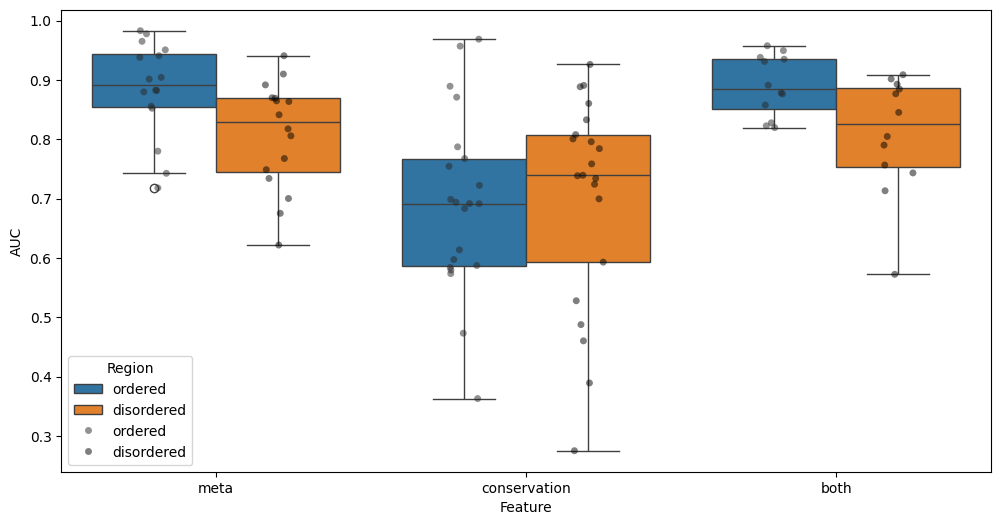

In [22]:
keep_feature = ['meta', 'conservation', 'both']
result_data_auc_plot_df = result_data_auc_df[result_data_auc_df['feature'].isin(keep_feature)]

plt.figure(figsize=(12, 6))
sns.boxplot(data=result_data_auc_plot_df, x='feature', y='AUC', hue='region')
sns.stripplot(data=result_data_auc_plot_df, x='feature', y='AUC', hue='region', 
              dodge=True, jitter=True, color='black', alpha=0.5, marker='o')

#plt.title("Paired Grouped Box Plot of AUC by Feature and Region with Jitter")
plt.ylabel("AUC")
plt.xlabel("Feature")
plt.legend(title="Region")
plt.show()

In [23]:
result_data_auc_plot_df

,name,AUC,AUC_CI_low,AUC_CI_high,PI_AUC,PR_AUC_low,PR_AUC_high,F1_Score,F1_CI_low,F1_CI_high,FRP_Score,FRP_CI_low,FRP_CI_high,TYPE,region,error_low,error_high,feature
0,MetaRNN,0.983111,0.982468,0.983754,0.982831,0.982144,0.983519,0.946059,0.944533,0.947585,0.063374,0.060841,0.065907,dbNSFP Predictor,ordered,0.000643,0.000643,meta
1,ClinPred,0.977885,0.977165,0.978605,0.979298,0.978634,0.979962,0.922562,0.921002,0.924123,0.081712,0.077101,0.086324,dbNSFP Predictor,ordered,0.000720,0.000720,meta
2,PHACTboost,0.968889,0.967915,0.969863,0.961641,0.960166,0.963115,0.918812,0.917102,0.920523,0.080849,0.076857,0.084842,dbNSFP Predictor,ordered,0.000974,0.000974,conservation
3,BayesDel_addAF,0.965301,0.964276,0.966326,0.954273,0.952497,0.956049,0.916974,0.915388,0.918560,0.093020,0.090060,0.095979,dbNSFP Predictor,ordered,0.001025,0.001025,meta
4,VARITY_R,0.957781,0.956669,0.958894,0.959942,0.958844,0.961039,0.898055,0.896207,0.899903,0.083544,0.079882,0.087205,dbNSFP Predictor,ordered,0.001113,0.001113,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,H1-hESC_fitCons,0.528023,0.522817,0.533229,0.601168,0.595929,0.606408,0.558414,0.553233,0.563594,0.524349,0.517127,0.531572,dbNSFP Predictor,disordered,0.005206,0.005206,conservation
105,integrated_fitCons,0.487850,0.483343,0.492356,0.565320,0.560241,0.570399,0.455274,0.450543,0.460006,0.546572,0.525620,0.567524,dbNSFP Predictor,disordered,0.004506,0.004506,conservation
107,HUVEC_fitCons,0.460429,0.455599,0.465259,0.563584,0.557955,0.569214,0.578177,0.573972,0.582382,0.306392,0.299477,0.313307,dbNSFP Predictor,disordered,0.004830,0.004830,conservation
108,GM12878_fitCons,0.389432,0.384896,0.393969,0.501141,0.496265,0.506018,0.449818,0.445370,0.454267,0.543161,0.534401,0.551920,dbNSFP Predictor,disordered,0.004537,0.004537,conservation


/tmp/ipykernel_1449184/3532565265.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=result_data_auc_plot_df, x='region', y='AUC', palette='Set3')
/tmp/ipykernel_1449184/3532565265.py:12: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  stripplot = sns.stripplot(data=result_data_auc_plot_df, x='region', y='AUC', hue='region',
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


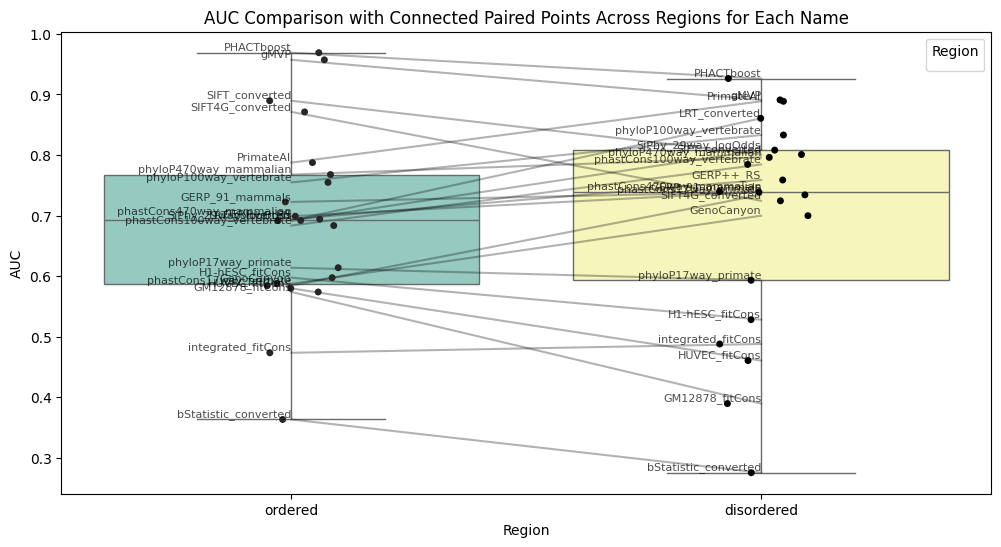

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the feature to keep
keep_feature = ['conservation']
result_data_auc_plot_df = result_data_auc_df[result_data_auc_df['feature'].isin(keep_feature)]

plt.figure(figsize=(12, 6))

# Plot boxplot and stripplot with hue as 'region'
sns.boxplot(data=result_data_auc_plot_df, x='region', y='AUC', palette='Set3')
stripplot = sns.stripplot(data=result_data_auc_plot_df, x='region', y='AUC', hue='region', 
                          dodge=False, jitter=True, color='black', marker='o')

# Get the unique order of regions from the data
region_order = result_data_auc_plot_df['region'].unique()

# Connect points across regions by 'name' and annotate
for name, sample_data in result_data_auc_plot_df.groupby('name'):
    # Ensure that sample_data is sorted by region to connect the points in order
    sample_data = sample_data.sort_values(by='region')
    
    # Get x positions based on the order of regions on the x-axis
    x_positions = [list(region_order).index(region) for region in sample_data['region']]
    
    # Plot line connecting points for each unique 'name'
    plt.plot(x_positions, sample_data['AUC'], color='black', alpha=0.3)
    
    # Annotate each point with the 'name'
    for x, y in zip(x_positions, sample_data['AUC']):
        plt.text(x, y, str(name), ha='right', va='bottom', fontsize=8, color='black', alpha=0.7)

# Customize the plot
plt.ylabel("AUC")
plt.xlabel("Region")
plt.title("AUC Comparison with Connected Paired Points Across Regions for Each Name")
plt.legend(title="Region", loc="upper right")
plt.show()

/tmp/ipykernel_1449184/2278893858.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=result_data_auc_plot_df, x='region', y='AUC', palette='Set3')
/tmp/ipykernel_1449184/2278893858.py:9: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  stripplot = sns.stripplot(data=result_data_auc_plot_df, x='region', y='AUC', hue='region',
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


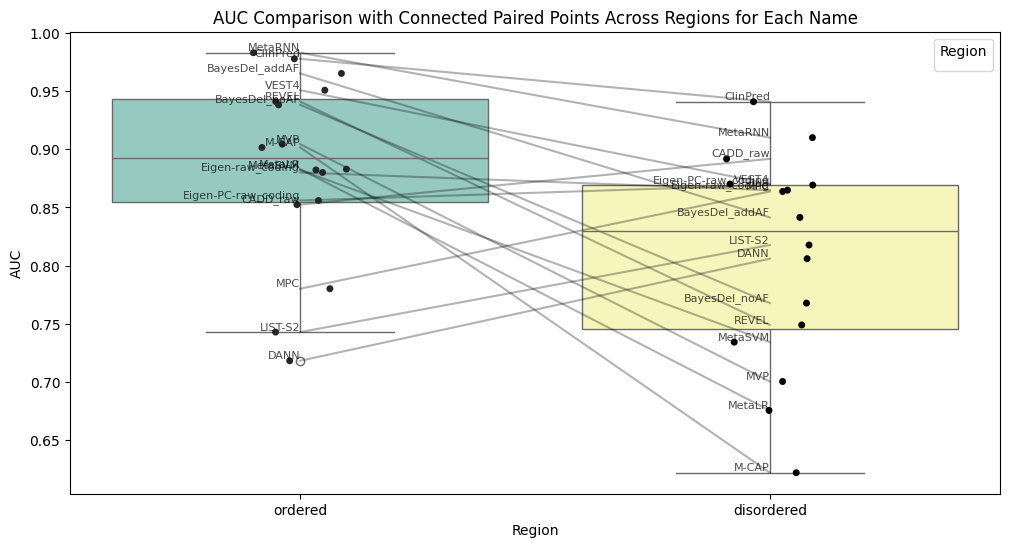

In [25]:

# Define the feature to keep
keep_feature = ['meta']
result_data_auc_plot_df = result_data_auc_df[result_data_auc_df['feature'].isin(keep_feature)]

plt.figure(figsize=(12, 6))

# Plot boxplot and stripplot with hue as 'region'
sns.boxplot(data=result_data_auc_plot_df, x='region', y='AUC', palette='Set3')
stripplot = sns.stripplot(data=result_data_auc_plot_df, x='region', y='AUC', hue='region', 
                          dodge=False, jitter=True, color='black', marker='o')

# Get the unique order of regions from the data
region_order = result_data_auc_plot_df['region'].unique()

# Connect points across regions by 'name' and annotate
for name, sample_data in result_data_auc_plot_df.groupby('name'):
    # Ensure that sample_data is sorted by region to connect the points in order
    sample_data = sample_data.sort_values(by='region')
    
    # Get x positions based on the order of regions on the x-axis
    x_positions = [list(region_order).index(region) for region in sample_data['region']]
    
    # Plot line connecting points for each unique 'name'
    plt.plot(x_positions, sample_data['AUC'], color='black', alpha=0.3)
    
    # Annotate each point with the 'name'
    for x, y in zip(x_positions, sample_data['AUC']):
        plt.text(x, y, str(name), ha='right', va='bottom', fontsize=8, color='black', alpha=0.7)

# Customize the plot
plt.ylabel("AUC")
plt.xlabel("Region")
plt.title("AUC Comparison with Connected Paired Points Across Regions for Each Name")
plt.legend(title="Region", loc="upper right")
plt.show()

/tmp/ipykernel_1449184/3152912770.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=result_data_auc_plot_df, x='region', y='AUC', palette='Set3')
/tmp/ipykernel_1449184/3152912770.py:9: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  stripplot = sns.stripplot(data=result_data_auc_plot_df, x='region', y='AUC', hue='region',
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


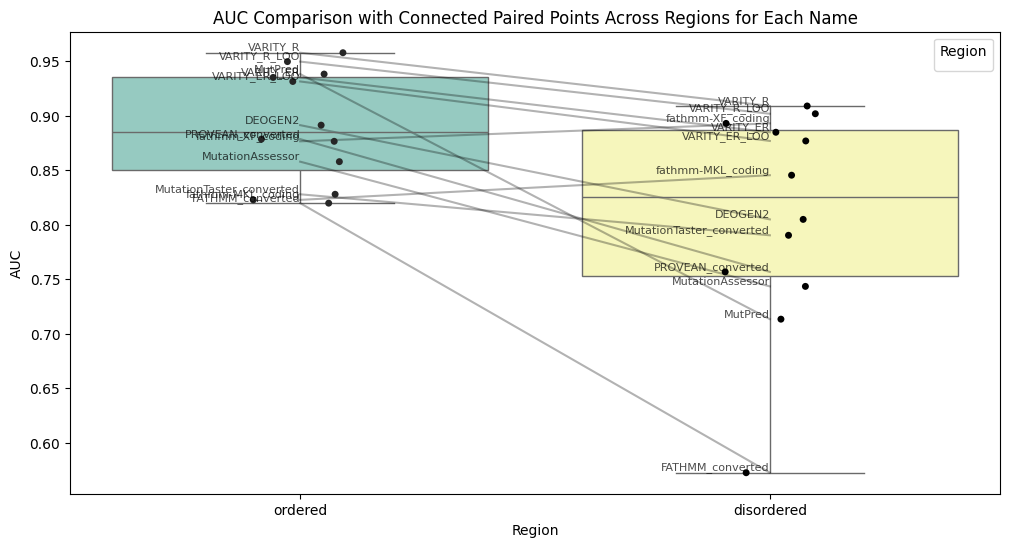

In [26]:
# Define the feature to keep
keep_feature = ['both']
result_data_auc_plot_df = result_data_auc_df[result_data_auc_df['feature'].isin(keep_feature)]

plt.figure(figsize=(12, 6))

# Plot boxplot and stripplot with hue as 'region'
sns.boxplot(data=result_data_auc_plot_df, x='region', y='AUC', palette='Set3')
stripplot = sns.stripplot(data=result_data_auc_plot_df, x='region', y='AUC', hue='region', 
                          dodge=False, jitter=True, color='black', marker='o')

# Get the unique order of regions from the data
region_order = result_data_auc_plot_df['region'].unique()

# Connect points across regions by 'name' and annotate
for name, sample_data in result_data_auc_plot_df.groupby('name'):
    # Ensure that sample_data is sorted by region to connect the points in order
    sample_data = sample_data.sort_values(by='region')
    
    # Get x positions based on the order of regions on the x-axis
    x_positions = [list(region_order).index(region) for region in sample_data['region']]
    
    # Plot line connecting points for each unique 'name'
    plt.plot(x_positions, sample_data['AUC'], color='black', alpha=0.3)
    
    # Annotate each point with the 'name'
    for x, y in zip(x_positions, sample_data['AUC']):
        plt.text(x, y, str(name), ha='right', va='bottom', fontsize=8, color='black', alpha=0.7)

# Customize the plot
plt.ylabel("AUC")
plt.xlabel("Region")
plt.title("AUC Comparison with Connected Paired Points Across Regions for Each Name")
plt.legend(title="Region", loc="upper right")
plt.show()